# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import time
from ddpg_agent import Agent
from collections import deque
import torch
from itertools import count
import matplotlib.pyplot as plt
%matplotlib inline

### 2 Load the environment

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name='Reacher_Windows_x86_64/Reacher.exe')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 3. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 4. Test Environment by taking random actions

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.10599999763071537


When finished, you can close the environment.

### 5. Train the Agent with the DDPG algorithm!

Firts we will define the training function. This function recieves as input parameters:

    - `agent`: The agent to be trained.
    - `n_episodes`: The number of episodes to train the agent.
    - `summary_freq`: Frequency to print the average of the training process.

This function saves a the agent's critic and actor neuronal network weights in a file called `critic_final.pth` and `actor_final.pth` respectively. As the training process takes a long time, this function also save checkpoints of the weights of the neuronal networks in files called `checkpoint_critic.pth` and `checkpoint_actor.pth`. Finally, the function returns a log of the scores and the 100th moving average scores obtained along the training process.

In [6]:
def ddpg(agent, n_episodes=1000, summary_freq=10):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    episode_scores = []                 # list containing scores from each episode
    average_scores = []                 # list containing the 100th average window scores
    scores_window = deque(maxlen=100)   # last 100 scores
    start_time = time.time()            # init time
    
    # -------------------------- Training ------------------------------------#
    for i_episode in range(1, n_episodes+1):
        timer = time.time()
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        scores = np.zeros(num_agents)
        a = 0
        while True:
            print("\r {}".format(a),end="")
            a = a + 1
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards                   
            dones = env_info.local_done                  
            agent.step(states, actions, rewards, next_states, dones)
            states = next_states
            scores += rewards
            if np.any(dones):
                timer = time.time()-timer
                break
        
        episode_score = np.mean(scores)                   # calculate episode score
        scores_window.append(episode_score)               # save most recent score
        episode_scores.append(episode_score)              # save most recent score
        average_scores.append(np.mean(scores_window))     # save current average score

        # ------------------------ report and checkpoint saaving ----------------#
        training_time =  time.time()-start_time
        hours = int(training_time // 3600)
        minutes = int(training_time % 3600 // 60)
        seconds = training_time % 60
        print('\rEpisode {}\tEpisode Score: {:.2f}\tEpisode time: {:.2f}'.format(i_episode,
                                                                           episode_score,
                                                                           timer), 
                                                                           end="\n")
        
        if i_episode % summary_freq == 0:
            print('***\033[1mEpisode {}\tAverage Score: {:.2f}\tTime training: {:d}:{:d}:{:05.2f}***\033[0m'.format(i_episode, 
                                                                                    average_scores[-1],
                                                                                    hours,
                                                                                    minutes,
                                                                                    seconds))
        if i_episode % summary_freq == 0 and average_scores[-1] >= 25:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            
        if average_scores[-1]>=30:
            print('\n\033[1m\033[92mEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}\tTraining time: {:d}:{:d}:{:05.2f}\033[0m'.format(i_episode,
                                                                                                          average_scores[-1],                                                                                                                                                                     hours,
                                                                                                          minutes,
                                                                                                          seconds))
            torch.save(agent.actor_local.state_dict(), 'actor_final.pth')
            torch.save(agent.critic_local.state_dict(), 'critic_final.pth')
            break
    return episode_scores, average_scores

After we have the training function, we have to instantiate the agent and pass it as input to the training function. For this training we are going to use the default hyperparameters of the training function.

In [7]:
agent = Agent(state_size=state_size, action_size=action_size, random_seed=8)
scores, average_scores = ddpg(agent)   

Episode 1	Episode Score: 0.53	Episode time: 19.56
Episode 2	Episode Score: 0.65	Episode time: 18.17
Episode 3	Episode Score: 0.62	Episode time: 18.24
Episode 4	Episode Score: 0.49	Episode time: 18.62
Episode 5	Episode Score: 0.36	Episode time: 18.26
Episode 6	Episode Score: 0.62	Episode time: 18.28
Episode 7	Episode Score: 0.90	Episode time: 18.33
Episode 8	Episode Score: 0.91	Episode time: 18.61
Episode 9	Episode Score: 1.09	Episode time: 18.66
Episode 10	Episode Score: 1.21	Episode time: 19.09
***Episode 10	Average Score: 0.74	Time training: 0:3:05.83***
Episode 11	Episode Score: 0.99	Episode time: 18.88
Episode 12	Episode Score: 1.02	Episode time: 19.15
Episode 13	Episode Score: 1.13	Episode time: 19.29
Episode 14	Episode Score: 1.33	Episode time: 20.38
Episode 15	Episode Score: 0.98	Episode time: 20.22
Episode 16	Episode Score: 1.51	Episode time: 19.99
Episode 17	Episode Score: 1.73	Episode time: 20.17
Episode 18	Episode Score: 1.90	Episode time: 20.41
Episode 19	Episode Score: 1.5

Let's plot the progress of our agent along it's training process

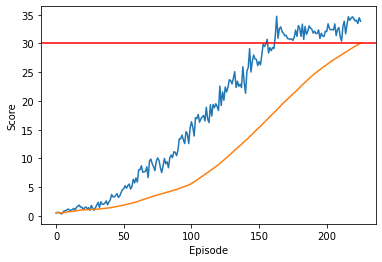

In [9]:

fig = plt.figure()
plt.plot(np.arange(len(scores)),scores)
plt.plot(np.arange(len(average_scores)),average_scores)
plt.axhline(y=30,color='r')
plt.ylabel("Score")
plt.xlabel("Episode")
plt.show()

### 6 Watch Smart Agent play in the current environment.

We can load this weights to watch the smart agent play as shown in the next cell. 

In [12]:
NUMBER_OF_EPISODES = 1

#Instantiate untrained agent
agent = Agent(state_size=state_size, action_size=action_size, random_seed=8)
#Load actor weights from file
agent.actor_local.load_state_dict(torch.load('actor_final.pth'))
#Load critic weights from file
agent.critic_local.load_state_dict(torch.load('critic_final.pth'))

for i in range(NUMBER_OF_EPISODES):
    env_info = env.reset(train_mode=False)[brain_name]
    states = env_info.vector_observations
    scores = np.zeros(num_agents)
    agent.reset()
    while True:
        actions = agent.act(states)
        env_info = env.step(actions)[brain_name]
        next_states = env_info.vector_observations
        rewards = env_info.rewards
        dones = env_info.local_done
        scores += rewards
        states = next_states
        if np.any(dones):
            break
    if  np.mean(scores)>= 30:
        print("Congratulations your score is {}".format(np.mean(scores)))
    else:
        print("Buh! you only scored {}. Try again".format(np.mean(scores)))

Congratulations your score is 31.19949930263683


### 5. Train the Agent with the DDPG algorithm!

In [13]:
 env.close()